## Customer segementation based on their buying pattern using k means clustering

In [1]:
import pickle
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 150)
# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (14,10) #figure size
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()



In [2]:
root = '/Users/divyamittal/Desktop/Project/InstaCart/Sample/'

aisles = pd.read_csv(root +'aisles.csv')
departments = pd.read_csv(root +'departments.csv')
orders = pd.read_csv(root +'orders.csv')
order_products_prior = pd.read_csv(root +'order_products__prior.csv')
order_products_train = pd.read_csv(root +'order_products__train.csv')
products = pd.read_csv(root +'products.csv')


## Data Analysis

In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
aisles.shape

(134, 2)

In [5]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
departments.shape

(21, 2)

In [7]:
print(orders.shape)
orders.head()
orders.sort_values('order_id')

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0
3355525,2,202279,prior,3,5,9,8.0
3417191,3,205970,prior,16,5,17,12.0
2958007,4,178520,prior,36,1,9,7.0
2593373,5,156122,prior,42,6,16,9.0
...,...,...,...,...,...,...,...
1809968,3421079,108687,prior,6,1,13,0.0
877324,3421080,52726,prior,2,1,11,2.0
1949724,3421081,117076,prior,1,3,11,NaN
2903252,3421082,175185,prior,23,2,18,4.0


In [8]:
print(order_products_prior.shape)
order_products_prior.head()
order_products_prior.sort_values('order_id')

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434481,3421083,21162,3,0
32434480,3421083,45309,2,0
32434479,3421083,7854,1,0
32434482,3421083,18176,4,1


In [9]:
print(order_products_train.shape)
order_products_train.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
products.head()
products.sort_values('aisle_id')

,product_id,product_name,aisle_id,department_id
33398,33399,Red Lentil Dahl Soup,1,20
24069,24070,Spicy Homestyle Guacamole,1,20
44600,44601,Organic Classic Gazpacho Chilled Vegetable Soup,1,20
31599,31600,Jamaican Jerk Hemp Seed Salad,1,20
38693,38694,BBQ Chopped Salad,1,20
...,...,...,...,...
2499,2500,Cava,134,5
21320,21321,Dry Sake,134,5
33683,33684,California Champagne Sweet Rose,134,5
46379,46380,Champagne Brut Rose,134,5


As it can be observed from the data that a particular product belongs to a particluar aisle and department. When we checked the data shape, it is observed that the products are classified into 21 departments which is further classified into 134 aisles.
As the data provide is already segregated into prior, training and testing dat. Lets explore dividing the data considering prior and training data.

### DataSet Preparation

In [11]:
# As the data is divided into prios and training, lets merge the data and explore further into it.
order_prior=order_products_prior[['order_id', 'product_id']]
print(order_prior.shape)
order_train=order_products_train[['order_id', 'product_id']]
print(order_train.shape)
final_order=pd.concat([order_prior, order_train])
print(final_order.shape)
final_order.head()


(32434489, 2)
(1384617, 2)
(33819106, 2)


,order_id,product_id
0,2,33120
1,2,28985
2,2,9327
3,2,45918
4,2,30035


## Find regular and irregular users of instacart

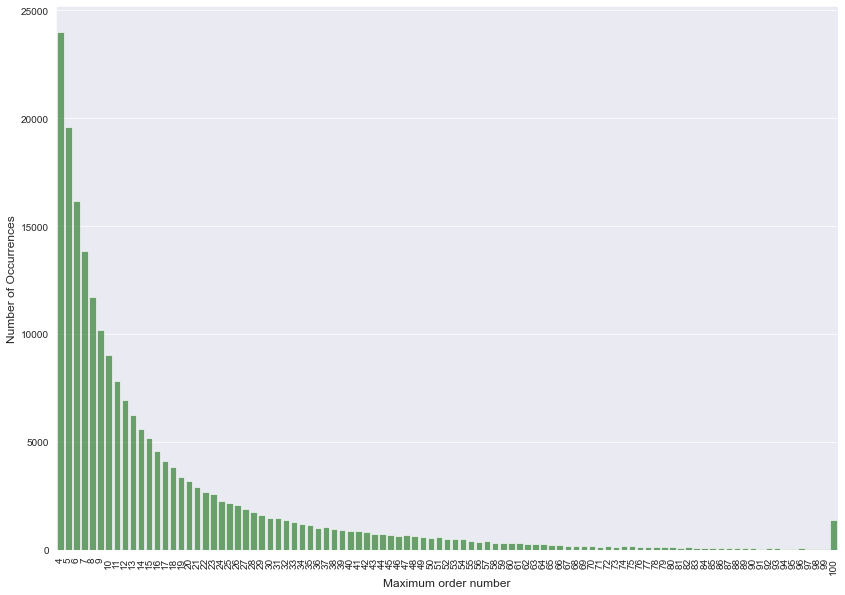

,user_id,total_order
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [12]:
# As the data is divided based on user buying pattern, it is necesaary to understand how many orders every user has placed till now.
user_with_total_order_count=orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
user_with_total_order_count.rename(columns={"order_number":"total_order"},inplace=True)
user_orders = user_with_total_order_count.total_order.value_counts()
pie, ax = plt.subplots(figsize=[14,10])
sns.barplot(user_orders.index, user_orders.values, alpha=0.6, color='green')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()
user_with_total_order_count.head()

From this graph, it can be inferred that the maximum order placed by the users are 4. It can be inferred from the dataset that instacart   is not able to hold the customers and maximum buyers has ordered just four items and left the store.
We will be clustering our users based on how many orders they have placed. As there are maximum users who have placed orders less than 10. We will try to find whether they are ordering any common product due to which it is happening.
We will also segregate the frequent users by considering users who placed orders more than 20.

In [13]:
user_product_more_than_20=user_with_total_order_count[user_with_total_order_count['total_order']>20]
user_product_less_than_10=user_with_total_order_count[user_with_total_order_count['total_order']<10]
user_product_less_than_10

,user_id,total_order
3,4,6
4,5,5
5,6,4
7,8,4
8,9,4
...,...,...
206195,206196,5
206197,206198,8
206202,206203,6
206203,206204,5


In [14]:
user_product_more_than_20.sort_values('total_order')


,user_id,total_order
6,7,21
77256,77257,21
77216,77217,21
179507,179508,21
77063,77064,21
...,...,...
17697,17698,100
37085,37086,100
17741,17742,100
144971,144972,100


In [15]:
user_product_less_than_10.sort_values('total_order')

,user_id,total_order
103528,103529,4
96237,96238,4
96239,96240,4
96244,96245,4
96254,96255,4
...,...,...
189589,189590,9
94985,94986,9
94994,94995,9
35202,35203,9


In [16]:
merged_order_product = final_order.merge(products,on='product_id') #merge the department based on aisle and product id
merged_order_product

,order_id,product_id,product_name,aisle_id,department_id
0,2,33120,Organic Egg Whites,86,16
1,26,33120,Organic Egg Whites,86,16
2,120,33120,Organic Egg Whites,86,16
3,327,33120,Organic Egg Whites,86,16
4,390,33120,Organic Egg Whites,86,16
...,...,...,...,...,...
33819101,2269288,27499,Non-Dairy Coconut Seven Layer Bar,100,21
33819102,2507248,27499,Non-Dairy Coconut Seven Layer Bar,100,21
33819103,2271346,37703,Ultra Sun Blossom Liquid 90 loads Fabric Enhan...,75,17
33819104,3004244,43725,Sweetart Jelly Beans,100,21


In [17]:
#check count of products in every aisle and concatenate user based on their order id
order_per_aisle = merged_order_product[['order_id','aisle_id']]
order_per_aisle['product_count'] = order_per_aisle['aisle_id']
order_per_aisle = order_per_aisle.groupby(['order_id','aisle_id']).agg({'product_count': 'count'}).reset_index()
print(order_per_aisle.shape)
order_per_aisle.head()

(24329222, 3)


,order_id,aisle_id,product_count
0,1,21,1
1,1,24,2
2,1,83,2
3,1,95,1
4,1,108,1


In [18]:
aisle_products = merged_order_product.groupby('aisle_id').agg({'product_id': 'count'}).reset_index()
aisle_products = aisle_products.sort_values('product_id', ascending=False)
aisle_products = aisle_products.merge(aisles,on='aisle_id')
aisle_products.rename(columns={"product_id": "total_products_purchased"}, inplace=True)
aisle_products.head()


,aisle_id,total_products_purchased,aisle
0,24,3792661,fresh fruits
1,83,3568630,fresh vegetables
2,123,1843806,packaged vegetables fruits
3,120,1507583,yogurt
4,21,1021462,packaged cheese


In [19]:
#calculate percentage of how much products are purchased from every aisle
aisle_products['percentage'] = aisle_products['total_products_purchased']/aisle_products.total_products_purchased.sum()
aisle_products

,aisle_id,total_products_purchased,aisle,percentage
0,24,3792661,fresh fruits,0.112146
1,83,3568630,fresh vegetables,0.105521
2,123,1843806,packaged vegetables fruits,0.054520
3,120,1507583,yogurt,0.044578
4,21,1021462,packaged cheese,0.030204
5,84,923659,milk,0.027312
6,115,878150,water seltzer sparkling water,0.025966
7,107,753739,chips pretzels,0.022287
8,91,664493,soy lactosefree,0.019648
9,112,608469,bread,0.017992


It can be inferred from above data that fresh fruits and fresh vegetables are the most import aisles for instacart as percentage of ordering from those aisle is more compared to other aisles.

In [20]:
#merge user id
order_user_aisle = order_per_aisle.merge(orders[['order_id','user_id']], on='order_id')
order_user_aisle

,order_id,aisle_id,product_count,user_id
0,1,21,1,112108
1,1,24,2,112108
2,1,83,2,112108
3,1,95,1,112108
4,1,108,1,112108
...,...,...,...,...
24329217,3421083,52,1,25247
24329218,3421083,74,1,25247
24329219,3421083,78,1,25247
24329220,3421083,92,4,25247


In [21]:
user_aisle_id = order_user_aisle[['user_id','aisle_id','product_count']]
user_aisle_count = user_aisle_id.groupby(['user_id','aisle_id']).agg({'product_count': 'sum'}).reset_index()
user_aisle_count

,user_id,aisle_id,product_count
0,1,21,9
1,1,23,13
2,1,24,5
3,1,45,2
4,1,53,3
...,...,...,...
5919835,206209,120,3
5919836,206209,121,7
5919837,206209,123,5
5919838,206209,130,3


In [22]:
# merge all users total orders with their id to calculate total products ordered from a particular aisle
user_aisle_order_more_than_20 = user_aisle_count.merge(user_product_more_than_20, how='right',on='user_id')
user_aisle_order_more_than_20

,user_id,aisle_id,product_count,total_order
0,7,1,1,21
1,7,13,2,21
2,7,16,1,21
3,7,17,3,21
4,7,21,5,21
...,...,...,...,...
2174152,206208,121,13,50
2174153,206208,123,71,50
2174154,206208,128,7,50
2174155,206208,130,2,50


In [23]:
# less than 10 
user_product_less_than_10 = user_aisle_count.merge(user_product_less_than_10, how='right',on='user_id')
user_product_less_than_10

,user_id,aisle_id,product_count,total_order
0,4,24,2,6
1,4,28,1,6
2,4,31,1,6
3,4,38,3,6
4,4,67,2,6
...,...,...,...,...
1913310,206205,100,2,4
1913311,206205,112,2,4
1913312,206205,116,2,4
1913313,206205,120,9,4


In [24]:
#Calculated total products ordered by top users from particular aisle
user_aisle_order_more_than_20['total_prod_count_for_20'] = user_aisle_order_more_than_20['product_count']*user_aisle_order_more_than_20['total_order']
user_aisle_order_more_than_20

,user_id,aisle_id,product_count,total_order,total_prod_count_for_20
0,7,1,1,21,21
1,7,13,2,21,42
2,7,16,1,21,21
3,7,17,3,21,63
4,7,21,5,21,105
...,...,...,...,...,...
2174152,206208,121,13,50,650
2174153,206208,123,71,50,3550
2174154,206208,128,7,50,350
2174155,206208,130,2,50,100


In [25]:
user_product_less_than_10['total_prod_count_for_10'] = user_product_less_than_10['product_count']*user_product_less_than_10['total_order']
user_product_less_than_10

,user_id,aisle_id,product_count,total_order,total_prod_count_for_10
0,4,24,2,6,12
1,4,28,1,6,6
2,4,31,1,6,6
3,4,38,3,6,18
4,4,67,2,6,12
...,...,...,...,...,...
1913310,206205,100,2,4,8
1913311,206205,112,2,4,8
1913312,206205,116,2,4,8
1913313,206205,120,9,4,36


### Find users percentage orders from every aisle to check their food buying patterns

In [26]:
def FindUserPercentageAndAislePercent(dataset,user_type,total_user):
    aisle_user = dataset[['aisle_id','user_id',user_type]]
    aisle_user = aisle_user.groupby(['aisle_id']).agg({'user_id':'count',user_type: 'sum'}).reset_index()
    aisle_user.rename(columns={"user_id": 'user_count'}, inplace=True)
    aisle_user = aisle_user.merge(aisles, how='left', on='aisle_id')
    total_user_count = total_user
    aisle_user['user_percent'] = aisle_user['user_count'] / total_user_count
    total_prod_count = sum(aisle_user[user_type])
    aisle_user['prod_percent'] = aisle_user[user_type] / total_prod_count
    return aisle_user
    

In [27]:
aisle_user=FindUserPercentageAndAislePercent(user_aisle_order_more_than_20,'total_prod_count_for_20',50731)
aisle_user


,aisle_id,user_count,total_prod_count_for_20,aisle,user_percent,prod_percent
0,1,9056,2159465,prepared soups salads,0.178510,0.002220
1,2,14159,2410223,specialty cheeses,0.279100,0.002478
2,3,25334,14483411,energy granola bars,0.499379,0.014889
3,4,19879,4972961,instant foods,0.391851,0.005112
4,5,14474,1621397,marinades meat preparation,0.285309,0.001667
5,6,8381,1039471,other,0.165205,0.001069
6,7,6511,1007155,packaged meat,0.128344,0.001035
7,8,6557,1046447,bakery desserts,0.129250,0.001076
8,9,25968,5795666,pasta sauce,0.511876,0.005958
9,10,3073,228680,kitchen supplies,0.060574,0.000235


In [28]:
aisle_user_less_than_10=FindUserPercentageAndAislePercent(user_product_less_than_10,'total_prod_count_for_10',1913315)
aisle_user_less_than_10

,aisle_id,user_count,total_prod_count_for_10,aisle,user_percent,prod_percent
0,1,5963,75094,prepared soups salads,0.003117,0.002181
1,2,8528,88550,specialty cheeses,0.004457,0.002572
2,3,20197,431926,energy granola bars,0.010556,0.012547
3,4,18514,263301,instant foods,0.009676,0.007648
4,5,8952,80791,marinades meat preparation,0.004679,0.002347
5,6,4835,43725,other,0.002527,0.001270
6,7,3811,36739,packaged meat,0.001992,0.001067
7,8,3467,37864,bakery desserts,0.001812,0.001100
8,9,22559,269032,pasta sauce,0.011791,0.007815
9,10,1702,13265,kitchen supplies,0.000890,0.000385


In [29]:
new_user_aisle_order_more_than_20 = user_aisle_order_more_than_20.merge(aisles, how='inner', on='aisle_id')
new_user_aisle_order_more_than_20 = new_user_aisle_order_more_than_20.groupby(['user_id','aisle_id']).agg({'product_count':'sum','total_order':'sum','total_prod_count_for_20': 'sum'}).reset_index()
new_user_aisle_order_more_than_20

,user_id,aisle_id,product_count,total_order,total_prod_count_for_20
0,7,1,1,21,21
1,7,13,2,21,42
2,7,16,1,21,21
3,7,17,3,21,63
4,7,21,5,21,105
...,...,...,...,...,...
2174152,206208,121,13,50,650
2174153,206208,123,71,50,3550
2174154,206208,128,7,50,350
2174155,206208,130,2,50,100


In [30]:
new_user_aisle_order_less_than_10 = user_product_less_than_10.merge(aisles, how='inner', on='aisle_id')
user_product_less_than_10 = user_product_less_than_10.groupby(['user_id','aisle_id']).agg({'product_count':'sum','total_order':'sum','total_prod_count_for_10': 'sum'}).reset_index()
new_user_aisle_order_less_than_10.sort_values('product_count')

,user_id,aisle_id,product_count,total_order,total_prod_count_for_10,aisle
956657,96150,53,1,7,7,cream
683145,128717,86,1,6,6,eggs
683146,128723,86,1,4,4,eggs
683147,128746,86,1,4,4,eggs
1361805,62897,116,1,8,8,frozen produce
...,...,...,...,...,...,...
64490,173753,24,102,9,918,fresh fruits
311742,35537,115,103,7,721,water seltzer sparkling water
118748,89597,38,112,7,784,frozen meals
1127000,54348,92,112,8,896,baby food formula


In [31]:
aisle_user=FindUserPercentageAndAislePercent(new_user_aisle_order_more_than_20,'total_prod_count_for_20',381895)
aisle_user=aisle_user[['aisle_id', 'user_count', 'total_prod_count_for_20','aisle','user_percent','prod_percent']]
aisle_user.drop_duplicates(inplace=True)
aisle_user

,aisle_id,user_count,total_prod_count_for_20,aisle,user_percent,prod_percent
0,1,9056,2159465,prepared soups salads,0.023713,0.002220
1,2,14159,2410223,specialty cheeses,0.037076,0.002478
2,3,25334,14483411,energy granola bars,0.066338,0.014889
3,4,19879,4972961,instant foods,0.052054,0.005112
4,5,14474,1621397,marinades meat preparation,0.037900,0.001667
5,6,8381,1039471,other,0.021946,0.001069
6,7,6511,1007155,packaged meat,0.017049,0.001035
7,8,6557,1046447,bakery desserts,0.017170,0.001076
8,9,25968,5795666,pasta sauce,0.067998,0.005958
9,10,3073,228680,kitchen supplies,0.008047,0.000235


In [32]:
aisle_user_less_than_10=FindUserPercentageAndAislePercent(new_user_aisle_order_less_than_10,'total_prod_count_for_10',1913315)
aisle_user_less_than_10=aisle_user_less_than_10[['aisle_id', 'user_count', 'total_prod_count_for_10','aisle','user_percent','prod_percent']]
aisle_user_less_than_10.drop_duplicates(inplace=True)
aisle_user_less_than_10

,aisle_id,user_count,total_prod_count_for_10,aisle,user_percent,prod_percent
0,1,5963,75094,prepared soups salads,0.003117,0.002181
1,2,8528,88550,specialty cheeses,0.004457,0.002572
2,3,20197,431926,energy granola bars,0.010556,0.012547
3,4,18514,263301,instant foods,0.009676,0.007648
4,5,8952,80791,marinades meat preparation,0.004679,0.002347
5,6,4835,43725,other,0.002527,0.001270
6,7,3811,36739,packaged meat,0.001992,0.001067
7,8,3467,37864,bakery desserts,0.001812,0.001100
8,9,22559,269032,pasta sauce,0.011791,0.007815
9,10,1702,13265,kitchen supplies,0.000890,0.000385


In [33]:
aisle_user[['aisle','user_percent']]

,aisle,user_percent
0,prepared soups salads,0.023713
1,specialty cheeses,0.037076
2,energy granola bars,0.066338
3,instant foods,0.052054
4,marinades meat preparation,0.037900
5,other,0.021946
6,packaged meat,0.017049
7,bakery desserts,0.017170
8,pasta sauce,0.067998
9,kitchen supplies,0.008047


In [34]:
aisle_user_less_than_10[['aisle','user_percent']]

,aisle,user_percent
0,prepared soups salads,0.003117
1,specialty cheeses,0.004457
2,energy granola bars,0.010556
3,instant foods,0.009676
4,marinades meat preparation,0.004679
5,other,0.002527
6,packaged meat,0.001992
7,bakery desserts,0.001812
8,pasta sauce,0.011791
9,kitchen supplies,0.000890


## Remove essential aisles from Dataset

Remove essential aisles from the dataset as it will not make much difference to differentiate between different users. We have considered only users who are having order percentage less than 0.7.

In [35]:
def GetUserAvgPerAisle(aisle_user, user_list_based_on_group_division):   
    non_essential_aisle = aisle_user.loc[(aisle_user['user_percent'] < 0.7), 'aisle_id']
    user_list=user_list_based_on_group_division.merge(non_essential_aisle, how='inner', on='aisle_id')
    user_list['avg'] = user_list['product_count']/user_list['total_order']
    return user_list[['user_id','aisle_id','avg']]



In [36]:
final_list_for_user_more_than_20=GetUserAvgPerAisle(aisle_user,new_user_aisle_order_more_than_20)
final_list_for_user_more_than_20

,user_id,aisle_id,avg
0,7,1,0.047619
1,101,1,0.142857
2,110,1,0.047619
3,140,1,0.038961
4,155,1,0.739130
...,...,...,...
2174152,205510,113,0.019608
2174153,205558,113,0.058824
2174154,205780,113,0.310345
2174155,205868,113,0.294118


In [37]:
final_list_for_user_less_than_10=GetUserAvgPerAisle(aisle_user_less_than_10,new_user_aisle_order_less_than_10)
final_list_for_user_less_than_10

,user_id,aisle_id,avg
0,4,24,0.333333
1,5,24,1.000000
2,8,24,0.750000
3,9,24,1.250000
4,10,24,2.333333
...,...,...,...
1913310,203269,113,0.200000
1913311,203593,113,0.166667
1913312,204059,113,0.125000
1913313,204392,113,0.333333


### Generate Dataset considering normalzation as well as non normalized data

In [38]:
def GenerateDataSet(final_list):
    data = pd.pivot_table(final_list, values='avg', index=['user_id'],columns=['aisle_id'], aggfunc=np.sum, fill_value=0)
    data.reset_index(inplace=True)
    index_match = data['user_id']
    data.set_index('user_id', inplace=True)
    return data,index_match

In [39]:
data,index_match=GenerateDataSet(final_list_for_user_more_than_20)
data

aisle_id,1,2,3,4,5,6,7,8,9,10,...,125,126,127,128,129,130,131,132,133,134
user_id,,,,,,,,,,,,,,,,,,,,,
7,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.391304,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
17,0.000000,0.000000,0.000000,0.121951,0.097561,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.048780,0.000000,0.0,0.0,0.0
21,0.000000,0.000000,0.235294,0.029412,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
27,0.000000,0.024390,0.560976,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206200,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.083333,0.041667,0.0,0.0,0.0
206201,0.000000,0.212121,0.000000,0.181818,0.060606,0.000000,0.00,0.0,0.090909,0.0,...,0.000000,0.0,0.0,0.060606,0.151515,0.121212,0.303030,0.0,0.0,0.0
206202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.043478,0.000000,0.0,0.0,0.0


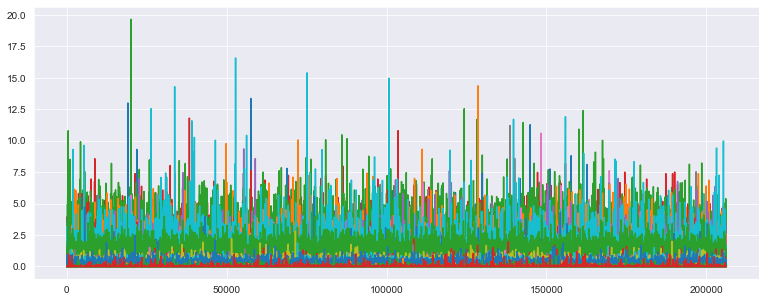

In [40]:
%matplotlib inline
plt.figure(figsize=(13,5))
plt.plot(data)

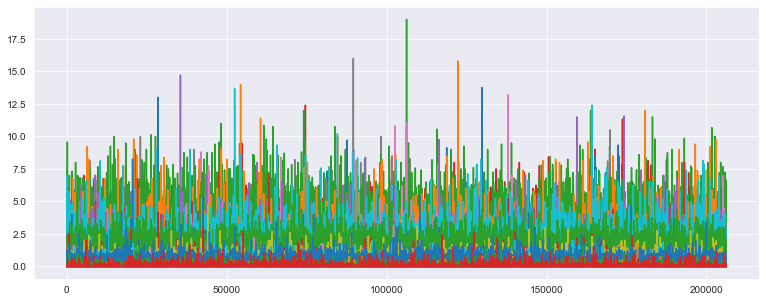

In [41]:
data_less_than_10,index_match_less_than_10=GenerateDataSet(final_list_for_user_less_than_10)
data_less_than_10.describe()
plt.figure(figsize=(13,5))
plt.plot(data_less_than_10)

In [42]:
from sklearn.preprocessing import StandardScaler
def ScaleData(data):
    scaler=StandardScaler()
    standardScaledData=scaler.fit_transform(data)   
    dataset=pd.DataFrame(standardScaledData,columns=list(data.columns))
    plt.figure(figsize=(13,5))
    plt.plot(dataset)
    return dataset

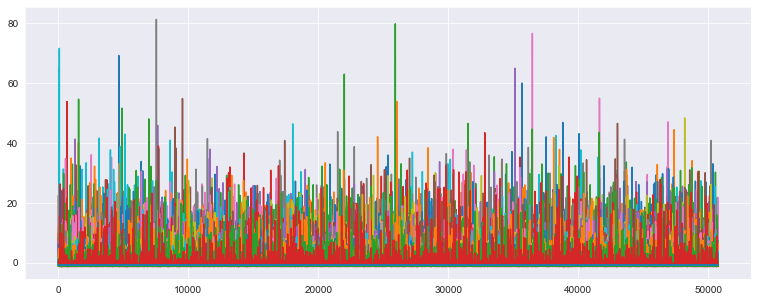

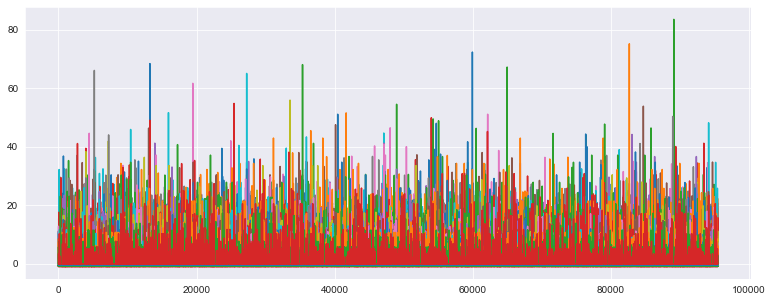

In [43]:
scaled_df_more_than_20=ScaleData(data);
scaled_df_less_than_10=ScaleData(data_less_than_10);

we are trying PCA on normalized as well as normal data and will compare the algorithm results to check which data is performing well on the model.

## Implement PCA to reduce the dimensions as there are 134 aisles 

In [44]:
# principal component analysis for dimension reduction
from sklearn.decomposition import PCA

In [45]:
def GeneratePCADataset(user_list,n_component):
    pca = PCA(n_components=n_component)
    result = pca.fit_transform(user_list)
    print(np.sum(pca.explained_variance_ratio_))
    return pd.DataFrame(result)

In [46]:
pca_less_than_10=GeneratePCADataset(data_less_than_10,50)
pca_less_than_10.describe()

0.9087781912306888


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,...,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04
mean,1.881546e-16,3.423191e-17,-2.791458e-17,1.257860e-16,1.327053e-16,-3.877077e-17,1.034777e-17,-7.404510e-17,-1.686247e-17,6.141976e-17,...,2.498949e-17,1.586968e-17,-1.580072e-17,-7.863062e-17,6.253369e-18,3.154991e-18,1.047073e-18,-1.464347e-17,2.475331e-17,1.124434e-17
std,1.400127e+00,7.637651e-01,6.090395e-01,5.054032e-01,4.486688e-01,4.383995e-01,4.228270e-01,4.096979e-01,3.659492e-01,3.401728e-01,...,1.729401e-01,1.686425e-01,1.662062e-01,1.634272e-01,1.617816e-01,1.590430e-01,1.579133e-01,1.553228e-01,1.537228e-01,1.497793e-01
min,-1.644550e+00,-6.296321e+00,-7.015914e+00,-7.048088e+00,-3.827354e+00,-6.119157e+00,-6.916237e+00,-3.713786e+00,-2.890565e+00,-7.193386e+00,...,-2.193427e+00,-2.726345e+00,-2.626125e+00,-1.091973e+00,-1.522022e+00,-1.007443e+00,-2.464244e+00,-1.447788e+00,-1.216060e+00,-1.208987e+00
25%,-1.074425e+00,-3.981197e-01,-3.156991e-01,-2.264158e-01,-2.167095e-01,-2.283932e-01,-1.159527e-01,-1.808319e-01,-1.839058e-01,-1.177283e-01,...,-5.283190e-02,-5.788997e-02,-6.417706e-02,-8.093901e-02,-7.231238e-02,-5.590123e-02,-6.549184e-02,-6.123890e-02,-7.915283e-02,-4.884368e-02
50%,-3.668297e-01,-9.918392e-02,-5.918372e-02,4.825344e-02,-1.419957e-02,-6.404509e-02,-2.612675e-02,-1.817217e-02,-1.111907e-02,4.218059e-02,...,5.714521e-03,-8.597673e-03,-1.755431e-03,-1.558909e-02,-2.232199e-03,-1.176738e-02,-1.122383e-02,-2.241535e-03,-1.141762e-02,-1.152304e-02
75%,6.956462e-01,3.677923e-01,2.709346e-01,2.457562e-01,2.154239e-01,1.927036e-01,5.987015e-02,1.237661e-01,1.553112e-01,1.576466e-01,...,7.054546e-02,4.134633e-02,5.886593e-02,6.230232e-02,6.434140e-02,3.113692e-02,5.102436e-02,5.653347e-02,6.846042e-02,2.766230e-02
max,1.172779e+01,8.174563e+00,9.393283e+00,7.778703e+00,1.054634e+01,9.629200e+00,1.305905e+01,9.737065e+00,1.369270e+01,1.044161e+01,...,2.535506e+00,3.038216e+00,2.701536e+00,2.450097e+00,1.883979e+00,5.202915e+00,2.586352e+00,1.945987e+00,1.747237e+00,6.657160e+00


In [47]:
pca_more_than_20=GeneratePCADataset(data,36)
pca_more_than_20.describe()

0.9026683125641238


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
count,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,...,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04
mean,3.694324e-16,-8.085998e-17,-5.247085e-17,2.573345e-17,-5.420191e-17,8.715506e-17,1.015638e-16,7.412174e-17,2.473661e-17,-6.261158e-18,...,1.233384e-17,-2.807290e-17,1.168414e-17,-1.100506e-16,6.287064e-17,3.550789e-17,1.652554e-17,-6.557693e-18,7.312125e-18,4.610218e-17
std,1.370017e+00,8.042364e-01,6.184847e-01,4.956847e-01,4.738720e-01,4.364330e-01,3.931963e-01,3.771803e-01,3.404759e-01,3.327937e-01,...,1.830357e-01,1.811596e-01,1.779766e-01,1.740042e-01,1.701100e-01,1.666153e-01,1.612055e-01,1.594943e-01,1.554426e-01,1.533885e-01
min,-1.996777e+00,-6.184150e+00,-7.107861e+00,-6.490515e+00,-3.490961e+00,-4.157198e+00,-2.949047e+00,-3.234101e+00,-6.678042e+00,-6.084010e+00,...,-1.495366e+00,-1.649991e+00,-1.752063e+00,-1.558677e+00,-1.536407e+00,-2.061170e+00,-1.416490e+00,-1.226607e+00,-1.567985e+00,-1.141449e+00
25%,-1.050982e+00,-4.189211e-01,-3.047736e-01,-2.899080e-01,-1.867164e-01,-2.243588e-01,-1.957298e-01,-2.006271e-01,-1.032881e-01,-1.500391e-01,...,-8.099654e-02,-9.551964e-02,-8.785161e-02,-9.243223e-02,-8.539528e-02,-6.600575e-02,-8.340485e-02,-8.624865e-02,-6.718475e-02,-7.482904e-02
50%,-2.580071e-01,-9.868221e-02,-1.280343e-02,-6.698450e-02,-3.329558e-02,-2.854213e-02,3.394924e-02,-2.137655e-03,4.349005e-02,-8.429760e-03,...,1.669930e-02,2.119505e-03,-1.110923e-02,-1.747478e-02,-4.705141e-03,7.967808e-03,-1.709108e-02,-2.081910e-02,4.605324e-03,-8.714182e-03
75%,7.509616e-01,3.580300e-01,2.779944e-01,2.250694e-01,1.031857e-01,1.746485e-01,2.196227e-01,1.784540e-01,1.486008e-01,1.576685e-01,...,9.543375e-02,9.187595e-02,6.219190e-02,7.503775e-02,8.228115e-02,8.121586e-02,5.945024e-02,6.008262e-02,6.617217e-02,5.804924e-02
max,1.056207e+01,9.977300e+00,1.113097e+01,7.427967e+00,1.176488e+01,6.746392e+00,7.136978e+00,1.030709e+01,9.262483e+00,8.578912e+00,...,4.831082e+00,1.963672e+00,4.251054e+00,1.966109e+00,2.159611e+00,4.008487e+00,2.553233e+00,1.958696e+00,1.976158e+00,3.178089e+00


In [48]:
pca_more_than_20_after_normalization=GeneratePCADataset(scaled_df_more_than_20,82)
pca_more_than_20_after_normalization.describe()
    

0.7377838232338049


,0,1,2,3,4,5,6,7,8,9,...,72,73,74,75,76,77,78,79,80,81
count,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,...,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04,5.073100e+04
mean,9.776248e-17,-4.197405e-16,3.846750e-16,-1.455864e-16,2.426489e-16,2.131639e-16,-7.516125e-17,2.602418e-16,-9.112710e-18,-1.466525e-16,...,2.178034e-16,3.513230e-16,-4.921607e-17,-3.492768e-18,4.295491e-16,-6.689656e-16,-4.926575e-16,5.343978e-17,-6.228205e-16,-6.937367e-16
std,2.967873e+00,2.288746e+00,1.868998e+00,1.637902e+00,1.462242e+00,1.411118e+00,1.370191e+00,1.297901e+00,1.273328e+00,1.233367e+00,...,8.865179e-01,8.840561e-01,8.830257e-01,8.809855e-01,8.771587e-01,8.732506e-01,8.695149e-01,8.675210e-01,8.652006e-01,8.613891e-01
min,-6.320552e+00,-8.669864e+00,-1.427661e+01,-1.631078e+01,-1.023366e+01,-1.485750e+01,-1.515953e+01,-1.557043e+01,-1.376403e+01,-1.000511e+01,...,-1.027069e+01,-8.602102e+00,-1.146332e+01,-8.165786e+00,-7.270408e+00,-8.650449e+00,-1.182136e+01,-7.636594e+00,-1.004678e+01,-8.246584e+00
25%,-2.064100e+00,-1.307058e+00,-9.880295e-01,-8.462600e-01,-7.225404e-01,-7.086402e-01,-6.406875e-01,-6.454213e-01,-6.422220e-01,-6.515526e-01,...,-4.231813e-01,-4.499236e-01,-4.293952e-01,-4.122713e-01,-4.417987e-01,-4.512565e-01,-4.371227e-01,-4.463498e-01,-4.314737e-01,-4.561455e-01
50%,-4.834729e-01,-3.354121e-01,-9.811463e-02,-1.221037e-01,-1.543779e-01,-2.035363e-02,-4.843688e-02,8.344520e-03,-1.957647e-02,4.872771e-03,...,3.747350e-03,-6.841891e-03,5.237887e-03,5.003124e-03,2.776452e-03,-8.677706e-03,7.256999e-03,5.297349e-03,7.054701e-03,-3.828637e-03
75%,1.480584e+00,7.952199e-01,8.615385e-01,7.826283e-01,4.981900e-01,6.268710e-01,5.416165e-01,6.806454e-01,6.090896e-01,6.535885e-01,...,4.346023e-01,4.455344e-01,4.213388e-01,4.078684e-01,4.372858e-01,4.510198e-01,4.379580e-01,4.409823e-01,4.295313e-01,4.455465e-01
max,2.520559e+01,2.862484e+01,2.815598e+01,2.638119e+01,3.364204e+01,1.620309e+01,2.872716e+01,1.937148e+01,1.672575e+01,1.265383e+01,...,1.322051e+01,1.293406e+01,1.884315e+01,2.111457e+01,9.081062e+00,9.965785e+00,1.222524e+01,1.135762e+01,1.073637e+01,9.933956e+00


In [49]:
pca_less_than_10_after_normalization=GeneratePCADataset(scaled_df_less_than_10,87)
pca_less_than_10_after_normalization.describe()

0.7360535466717548


,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
count,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,...,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04,9.548100e+04
mean,4.030598e-16,8.038917e-17,5.246877e-17,-1.985241e-16,-1.208326e-16,-3.690302e-16,-8.619371e-17,-7.676016e-17,-3.859392e-16,-2.882728e-16,...,2.572044e-17,2.878465e-16,2.773982e-16,-1.207663e-16,1.346253e-16,-5.617009e-16,-1.953126e-16,4.637702e-16,-6.974146e-16,-5.223540e-16
std,2.605152e+00,1.954675e+00,1.623131e+00,1.480274e+00,1.371750e+00,1.315410e+00,1.287795e+00,1.216995e+00,1.199139e+00,1.179254e+00,...,9.129300e-01,9.115515e-01,9.091615e-01,9.066172e-01,9.040801e-01,9.025652e-01,8.987008e-01,8.972068e-01,8.952498e-01,8.927300e-01
min,-5.033411e+00,-9.834673e+00,-1.932207e+01,-1.441447e+01,-5.412818e+00,-1.009697e+01,-1.802357e+01,-1.827884e+01,-1.821143e+01,-1.768754e+01,...,-6.700975e+00,-8.872921e+00,-8.843651e+00,-1.047321e+01,-8.089626e+00,-8.437798e+00,-1.199433e+01,-6.957009e+00,-9.684668e+00,-8.714582e+00
25%,-1.886412e+00,-1.086243e+00,-8.280351e-01,-6.926527e-01,-6.395327e-01,-6.642315e-01,-6.069349e-01,-5.900737e-01,-6.255706e-01,-5.856860e-01,...,-4.771820e-01,-4.693877e-01,-4.735871e-01,-4.318954e-01,-4.783587e-01,-4.886003e-01,-4.573040e-01,-4.618168e-01,-4.807083e-01,-4.487465e-01
50%,-4.902174e-01,-2.276692e-01,-1.047590e-01,-3.333901e-02,-2.426628e-01,2.888010e-02,6.681149e-02,6.013317e-03,-3.761598e-02,1.072013e-02,...,1.027092e-02,4.445746e-03,-5.185331e-03,-1.451669e-02,3.910585e-03,4.112263e-03,1.130994e-02,-1.002553e-02,2.597177e-03,1.097805e-02
75%,1.269370e+00,7.508502e-01,7.752183e-01,7.196626e-01,2.881864e-01,6.062674e-01,6.648328e-01,6.278236e-01,5.930712e-01,5.932646e-01,...,4.693293e-01,4.606349e-01,4.800869e-01,4.120140e-01,4.699822e-01,4.889243e-01,4.512805e-01,4.386429e-01,4.644700e-01,4.680213e-01
max,2.628147e+01,4.032018e+01,3.138297e+01,2.642048e+01,2.934768e+01,2.022677e+01,2.529517e+01,1.945450e+01,1.893807e+01,1.873031e+01,...,1.094839e+01,9.604653e+00,9.325036e+00,1.273416e+01,8.256290e+00,9.102876e+00,1.270903e+01,1.473808e+01,1.500969e+01,8.775016e+00


In [50]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [51]:
def plotElbowGraphForPCA(pcaModel):   
    df = pd.DataFrame(columns = ['cluster','inertia'])
    for n in range(1, 10):
        kmeans = KMeans(n_clusters=n, random_state=42).fit(pcaModel)
        df = df.append({'cluster':n, 'inertia': kmeans.inertia_}, ignore_index=True)
    plt.plot(df['cluster'],df['inertia'])
    plt.xticks(np.arange(1, 10)) #change the value of it
    plt.xlabel('cluster count')
    plt.ylabel('inertia')
    plt.title("Elbow graph")

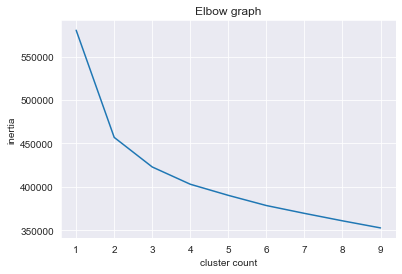

In [52]:
plotElbowGraphForPCA(pca_less_than_10)


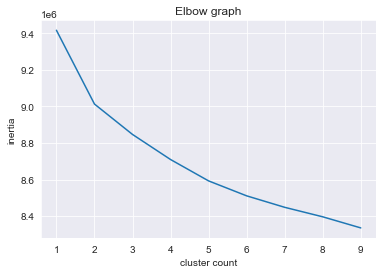

In [53]:
plotElbowGraphForPCA(pca_less_than_10_after_normalization)

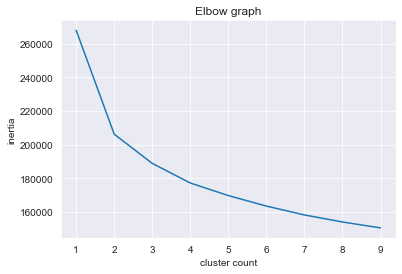

In [54]:
plotElbowGraphForPCA(pca_more_than_20)

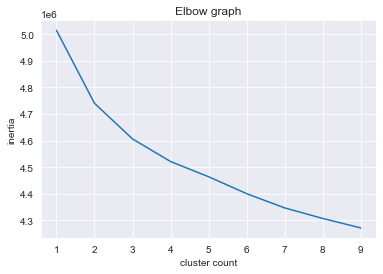

In [55]:
plotElbowGraphForPCA(pca_more_than_20_after_normalization)

In [56]:
from yellowbrick.cluster import InterclusterDistance
def CalculateCluster(model, n_cluster):
    modelKmean = KMeans(n_clusters=n_cluster, random_state=42)
    visualizer = InterclusterDistance(modelKmean)
    visualizer.fit(model)
    visualizer.show()

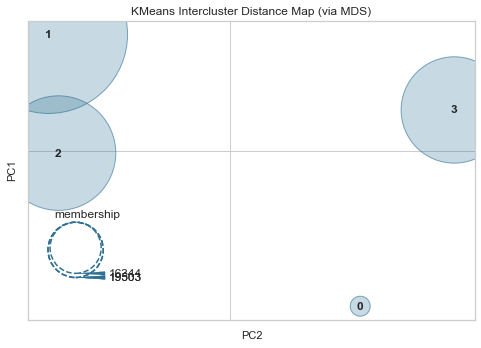

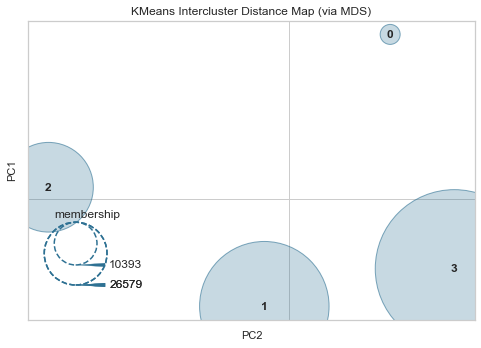

In [57]:
CalculateCluster(pca_less_than_10,4)
CalculateCluster(pca_less_than_10_after_normalization,4)


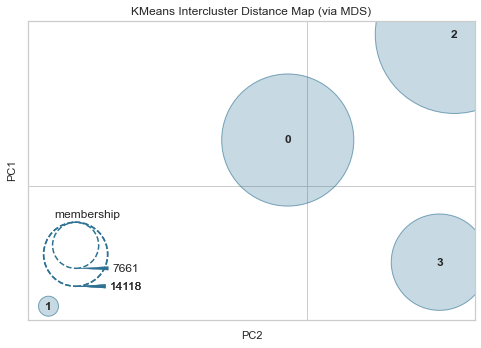

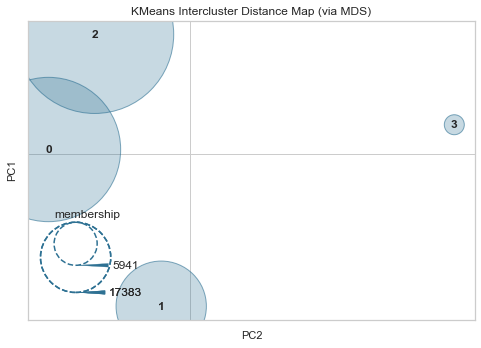

In [58]:
CalculateCluster(pca_more_than_20,4)
CalculateCluster(pca_more_than_20_after_normalization,4)

In [67]:
def createTemplateForCSV(n_clusters,dataset,user_info,name):
    modelForCluster=KMeans(n_clusters=n_clusters, random_state=42)
    modelForCluster.fit(dataset)
    y_kmean = pd.DataFrame(modelForCluster.predict(dataset))
    createCSV=y_kmean.copy(deep=True)
    createCSV.reset_index(inplace=True)
    createCSV.insert(1,'label',y_kmean)
    createCSV=createCSV[['index','label']]
    createCSV=user_info.merge(createCSV,on='index')
    createCSV=createCSV[['user_id','label']]
    createCSV.to_csv(name, index = True)
    return createCSV

In [60]:
user_info_more_than_20 = pd.DataFrame(index_match)
user_info_more_than_20.reset_index(inplace=True)

user_info_less_than_10 = pd.DataFrame(index_match_less_than_10)
user_info_less_than_10.reset_index(inplace=True)

In [99]:
result_more_than_20=createTemplateForCSV(4,pca_more_than_20,user_info_more_than_20, 'ClusterWithKMeanForMoreOrders.csv')
result_more_than_20_after_normalization=createTemplateForCSV(4,pca_more_than_20_after_normalization,user_info_more_than_20,'ClusterWithKMeanWithNormalization.csv')
result_less_than_10=createTemplateForCSV(4,pca_less_than_10,user_info_less_than_10,'ClusterWithKMeanForLessOrders.csv')
result_less_than_10_after_normalization=createTemplateForCSV(4,pca_less_than_10_after_normalization,user_info_less_than_10,'ClusterWithKMeanForLessOrdersWithNormalization.csv')

In [97]:
from sklearn.cluster import MiniBatchKMeans
def MiniBatchClustering(n_clusters,dataset,user_info,name):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(dataset)
    y_kmean = pd.DataFrame(modelForCluster.predict(dataset))
    createCSV=y_kmean.copy(deep=True)
    createCSV.reset_index(inplace=True)
    createCSV.insert(1,'label',y_kmean)
    createCSV=createCSV[['index','label']]
    createCSV=user_info.merge(createCSV,on='index')
    createCSV=createCSV[['user_id','label']]
    createCSV.to_csv(name, index = True)
    return createCSV

In [98]:
createTemplateForCSV(4,pca_more_than_20,user_info_more_than_20, 'MiniBatchClusterWithKMeanForMoreOrders.csv')
createTemplateForCSV(4,pca_more_than_20_after_normalization,user_info_more_than_20,'MiniBatchClusterWithKMeanWithNormalization.csv')
createTemplateForCSV(4,pca_less_than_10,user_info_less_than_10,'MiniBatchClusterWithKMeanForLessOrders.csv')
createTemplateForCSV(4,pca_less_than_10_after_normalization,user_info_less_than_10,'MiniBatchClusterWithKMeanForLessOrdersWithNormalization.csv')

,user_id,label
0,4,3
1,5,1
2,6,3
3,8,1
4,9,2
...,...,...
95476,206196,1
95477,206198,1
95478,206203,1
95479,206204,1


In [62]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [63]:
def CreateDendogram(n_cluster,dataset,user_info,name):
    model = AgglomerativeClustering(n_clusters=n_cluster)
    model = model.fit(dataset)
    y_agg = pd.DataFrame(model.labels_)
    createCSV=dataset.copy(deep=True)
    createCSV.reset_index(inplace=True)
    createCSV.insert(1,'label',y_agg)
    createCSV=createCSV[['index','label']]
    createCSV=user_info.merge(createCSV,on='index')
    createCSV=createCSV[['user_id','label']]
    createCSV.to_csv(name, index = True)
    plt.title('Hierarchical Clustering Dendrogram')
    plot_dendrogram(model, truncate_mode='level', p=4)
    #plt.axhline(y=100, color='black', linestyle='-')
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

In [64]:
#CreateDendogram(pca_more_than_20)


In [65]:
def SaveModelResultToCSV(n_cluster,dataset,user_info,name):
    modelAggl = AgglomerativeClustering(n_clusters=n_cluster)
    modelAggl.fit(dataset)
    y_agg = pd.DataFrame(modelAggl.labels_)
    createCSV=dataset.copy(deep=True)
    createCSV.reset_index(inplace=True)
    createCSV.insert(1,'label',y_agg)
    createCSV=createCSV[['index','label']]
    createCSV=user_info.merge(createCSV,on='index')
    createCSV=createCSV[['user_id','label']]
    createCSV.to_csv(name, index = True)
    

In [66]:
#SaveModelResultToCSV(4,pca_more_than_20,user_info_more_than_20, 'AgglometricClusterForMoreOrders.csv')
#SaveModelResultToCSV(4,pca_more_than_20_after_normalization,user_info_more_than_20,'AgglometricClusterWithNormalization.csv')
#SaveModelResultToCSV(4,pca_less_than_10,user_info_less_than_10,'AgglometricClusterForLessThan10.csv')
#SaveModelResultToCSV(4,pca_less_than_10_after_normalization,user_info_less_than_10,'AgglometricClusterForLessThan10WithNormalization.csv')